# Train and run wflow_sbm surrogate model

The surrogate emulates Actual Evapotranspiration and Volumetric Water Content (top 10 cm) produced from Wflow_sbm over the Alpine region at 1 km spatial resolution and daily time steps. 

The repository offers a very small dataset in the demodata folder. Uncomment the jupyter notebook cell "DEMO" and comment the cell "ALPS" in order to train the model.

The figures at the end of the notebook show the surrogate outputs on the Alps, however the training data are not yet available to reproduce the results.

In [212]:
#%load_ext autoreload
#%autoreload 2

In [213]:
import torch
import numpy as np
import xarray as xr
from pathlib import Path
import os
import random

import dask
from torch import nn


from hython.preprocess import reshape, apply_normalization
from hython.datasets.datasets import LSTMDataset
from hython.train_val import train_val
from hython.sampler import RegularIntervalSampler, DataLoaderSpatialSampler
from hython.metrics import mse_metric
from hython.losses import RMSELoss

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset

from hython.utils import missing_location_idx, reconstruct_from_missing, load, store_as_zarr
from hython.models.lstm import CustomLSTM


# viz
import matplotlib.pyplot as plt
from hython.viz import plot_sampler
from hython.utils import predict, prepare_for_plotting
from hython.viz import map_bias, map_pbias, map_pearson, map_at_timesteps, ts_compare, plot_sampler

def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(43)

# Settings

In [252]:

dynamic_names = ["precip", "pet", "temp"] #  WFLOW forcings, input features of the surrogate
static_names = [ 'thetaS', 'thetaR', 'RootingDepth', 'Swood','KsatVer'] # WFLOW static parameters, input features of the surrogate
target_names = [ "vwc","actevap" ] # WFLOW outputs, targets of the surrogate

fn_forcings =  "forcings.nc" 
fn_params = "staticmaps.nc"
fn_targets = "output.nc"

remove_lakes = True

# spatial sampling

spatial_sampling = True



train_start = "2016-01-01"
train_end = "2018-12-31"

test_start = "2019-01-01"
test_end = "2020-12-31"

In [253]:
# DEMO 

wflow_model = "datademo"

wd = Path("../data") / wflow_model

fp_dynamic_forcings = wd / fn_forcings 
fp_wflow_static_params = wd / fn_params
fp_target = wd / fn_targets

forcings = xr.open_dataset(fp_dynamic_forcings)
params = xr.open_dataset(fp_wflow_static_params)
targets = xr.open_dataset(fp_target).isel(lat=slice(None, None, -1))

In [254]:
# ALPS

wflow_model =  "adg1km_eobs" #

wd = Path("/mnt/CEPH_PROJECTS/InterTwin/Wflow/models") / wflow_model

input_dir_path = Path('/mnt/CEPH_PROJECTS/InterTwin/Wflow/models') / wflow_model
output_dir_path = Path('/mnt/CEPH_PROJECTS/InterTwin/surrogate/')
model_weigths_path = output_dir_path / "model_weights"
surrogate_input_path = Path("/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_training")

forcings = xr.open_dataset(input_dir_path / fn_forcings , chunks= {"time":200})
params = xr.open_dataset(input_dir_path / fn_params ,  chunks= {"time":200}).sel(layer=1)
targets = xr.open_dataset(input_dir_path / "run_default" / fn_targets, chunks= {"time":200}).sel(layer=1).isel(lat=slice(None, None, -1))

wflow_lakes = params.wflow_lakeareas.values

In [255]:
try:
    forcings = forcings.rename({"latitude":"lat", "longitude":"lon"})
    params = params.rename({"latitude":"lat", "longitude":"lon"})
except:
    pass

In [256]:
wflow_dem = params.wflow_dem

In [257]:
# select forcings, wflow parameters and targets
forcings = forcings[dynamic_names]
params = params[static_names]
targets = targets[target_names] 

In [258]:
## Show distribution of static parameters
# for i in static_names:
#     plt.figure(figsize=(2,2))
#     params[i].plot.hist(bins=100)

In [259]:
## Show map of static parameters
# for i in static_names:
#     plt.figure(figsize=(2,2))
#     params[i].plot()

# Hyper parameters

In [291]:
spatial_batch_size = 256
temporal_sampling_size = 150 
seq_length = 360 # days

hidden_size = 24

model_params={
    "input_size": 3, # forcings
    "hidden_size": hidden_size, 
    "output_size": len(target_names),
    "number_static_predictors": len(static_names), 

}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Preprocess

In [292]:

if remove_lakes:
    mask_lakes = (wflow_lakes > 0).astype(np.bool_)

# if timeslice:
#     forcings = forcings.sel(time=timeslice)
#     targets = targets.sel(time=timeslice)


train_range = slice(train_start,train_end)
test_range = slice(test_start, test_end)

In [293]:
# UNCOMMENT IF NOT LOADING PREPROCESSED INPUTS

# Reshape for training the LSTM model. 
# The hydrological model Wflow outputs datasets with shape( lat, lon, time, variable).
# The LSTM requires data with shape (gridcell, time, variable), therefore the original datasets need to be reshaped.

Xd, Xs, Y  = reshape(
                   forcings.sel(time = train_range), 
                   params, 
                   targets.sel(time = train_range),
                   return_type="dask"
                   )


Xd_test, Xs_test, Y_test  = reshape(
                   forcings.sel(time = test_range), 
                   params, 
                   targets.sel(time = test_range),
                   return_type="dask"
                   )

dynamic:  (40140, 1096, 3)  => (GRIDCELL, TIME, FEATURE)
static:  (40140, 5)  => (GRIDCELL, FEATURE)
target:  (40140, 1096, 2)  => (GRIDCELL, TIME, TARGET)
dynamic:  (40140, 731, 3)  => (GRIDCELL, TIME, FEATURE)
static:  (40140, 5)  => (GRIDCELL, FEATURE)
target:  (40140, 731, 2)  => (GRIDCELL, TIME, TARGET)


In [294]:
#Define the 2D missing values mask. Sampling
missing_mask = np.isnan(params[static_names[0]].values) #& mask_lakes

In [295]:
# UNCOMMENT TO SAVE to ZARR
# from numcodecs import Blosc
# compressor = Blosc(cname='zl4', clevel=4, shuffle=Blosc.BITSHUFFLE)
# store_as_zarr(Xd,url= f"/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_training/{wflow_model}.zarr",
#              group="xd", storage_options={"compressor":compressor})
# store_as_zarr(Y,url= f"/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_training/{wflow_model}.zarr",
#              group="y", storage_options={"compressor":compressor})
# store_as_zarr(Xs,url= f"/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_training/{wflow_model}.zarr",
#              group="xs", storage_options={"compressor":compressor})
# store_as_zarr(missing_mask,url= f"/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_training/{wflow_model}.zarr",
#              group="mask", storage_options={"compressor":compressor})

In [296]:
# ALPS
# starttime = int(365*2)
# Xd = dask.array.from_zarr(f"/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_training/{wflow_model}.zarr",component="xd")[:,starttime:,:]
# Xs = dask.array.from_zarr(f"/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_training/{wflow_model}.zarr",component="xs")
# Y = dask.array.from_zarr(f"/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_training/{wflow_model}.zarr",component="y")[:,starttime:,:]
# missing_mask = dask.array.from_zarr(f"/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_training/{wflow_model}.zarr",component="mask")

SamplerResult(
 - id_grid_2d: (180, 223) 
 - idx_sampled_1d: (1620,) 
 - idx_sampled_1d_nomissing: (624,)) 
 - idx_missing_1d: (24681,) 
 - sampled_grid_dims: (36, 45) 
 - xr_coords: Coordinates:
  * lat          (lat) float64 47.08 47.04 46.99 46.94 ... 45.57 45.52 45.48
  * lon          (lon) float64 10.29 10.34 10.38 10.43 ... 12.22 12.26 12.31
    layer        int64 1
    spatial_ref  int64 ...


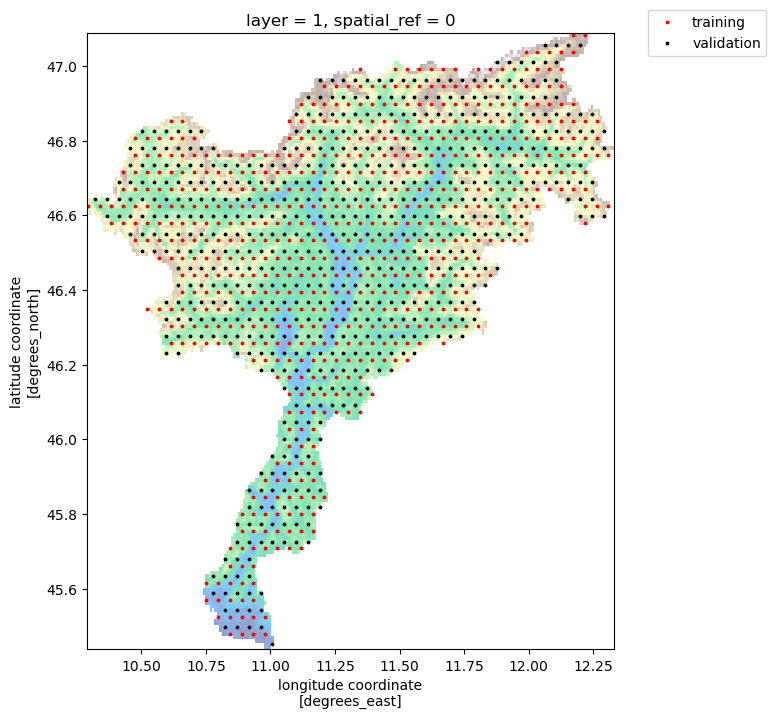

In [297]:
# Define the spatial samplers for both training and validation sets. Remeber the subsets should not overlap, so choose different origins.
if spatial_sampling:
    intervals = (5, 5) # every n km
    train_origin = (0, 0)
    val_origin = (3, 3)
    
    spatial_train_sampler = RegularIntervalSampler(intervals = intervals, origin = train_origin)
    spatial_val_sampler = RegularIntervalSampler(intervals = intervals, origin = val_origin) 

    # Apply the samplers: return the cell indices that can be used later in training and validation to sample the whole spatial domain.
    data2d  = params[static_names[0]] 
    
    sampler_train_meta = spatial_train_sampler.sampling_idx(data2d, missing_mask)
    sampler_val_meta = spatial_val_sampler.sampling_idx(data2d, missing_mask)

    # some useful metadata
    print(sampler_train_meta)

    # check location of training and validation sets
    _ = plot_sampler(params[static_names[0]], sampler_train_meta, sampler_val_meta, figsize= (8, 8 ), markersize = 3)
else:
    idx = missing_location_idx(Xs)

    Xd_nomissing = Xd[~idx]
    Xs_nomissing = Xs[~idx]
    Y_nomissing = Y[~idx]


In [298]:
# # Normalizing
if spatial_sampling:
    # # training
    _, d_m, d_std = apply_normalization(Xd[sampler_train_meta.idx_sampled_1d_nomissing], type = "spacetime", how ='standard')
    _, s_m, s_std = apply_normalization(Xs[sampler_train_meta.idx_sampled_1d_nomissing], type = "space", how ='standard')
    _, y_m, y_std = apply_normalization(Y[sampler_train_meta.idx_sampled_1d_nomissing], type = "spacetime", how ='standard')
    
    Xd = apply_normalization(Xd, type="spacetime", how="standard", m1 = d_m, m2 = d_std).compute()
    Xs = apply_normalization(Xs, type="space", how="standard",  m1 = s_m, m2 = s_std).compute()
    Y = apply_normalization(Y, type="spacetime",how="standard", m1 = y_m, m2 = y_std).compute()


    Xd_test = apply_normalization(Xd_test, type="spacetime", how="standard", m1 = d_m, m2 = d_std).compute()
    Xs_test = apply_normalization(Xs_test, type="space", how="standard",  m1 = s_m, m2 = s_std).compute()
    Y_test = apply_normalization(Y_test, type="spacetime",how="standard", m1 = y_m, m2 = y_std).compute()
else:
    _, d_m, d_std = apply_normalization(Xd_nomissing, type = "spacetime", how ='standard')
    _, s_m, s_std = apply_normalization(Xs_nomissing, type = "space", how ='standard')
    _, y_m, y_std = apply_normalization(Y_nomissing, type = "spacetime", how ='standard')

    Xd_nomissing = apply_normalization(Xd_nomissing, type="spacetime", how="standard", m1 = d_m, m2 = d_std).compute()
    Xs_nomissing = apply_normalization(Xs_nomissing, type="space", how="standard",  m1 = s_m, m2 = s_std).compute()
    Y_nomissing = apply_normalization(Y_nomissing, type="spacetime",how="standard", m1 = y_m, m2 = y_std).compute()

    Xd_test = apply_normalization(Xd_test, type="spacetime", how="standard", m1 = d_m, m2 = d_std).compute()
    Xs_test = apply_normalization(Xs_test, type="space", how="standard",  m1 = s_m, m2 = s_std).compute()
    Y_test = apply_normalization(Y_test, type="spacetime",how="standard", m1 = y_m, m2 = y_std).compute()

In [299]:
## Show distribution of static parameters
# for i in range(Xs.shape[1]):
#     plt.figure(figsize= (1, 1))
#     plt.hist(Xs[:,i], bins=100)

In [300]:
## Show distribution of targets
# for i in range(Y.shape[2]):
#     plt.figure(figsize= (1, 1))
#     plt.hist(Xs[:,i], bins=100)

# Prepare Model inputs

In [301]:
if spatial_sampling:
    Xs = torch.Tensor(Xs)
    Xd = torch.Tensor(Xd)
    Y = torch.Tensor(Y)
    
    Xs.shape, Xd.shape, Y.shape

    # init datasets
    dataset = LSTMDataset(Xd, Y, Xs)
    
    train_sampler = DataLoaderSpatialSampler(dataset, num_samples=100, sampling_indices = sampler_train_meta.idx_sampled_1d_nomissing.tolist())
    valid_sampler = DataLoaderSpatialSampler(dataset, num_samples=100, sampling_indices = sampler_val_meta.idx_sampled_1d_nomissing.tolist())
    
    train_loader = DataLoader(dataset, batch_size=spatial_batch_size, shuffle=False, sampler = train_sampler) # implement shuffling in the sampler!
    val_loader = DataLoader(dataset, batch_size=spatial_batch_size, shuffle=False, sampler = valid_sampler)
else:
    Xs_nms = torch.Tensor(Xs_nomissing)
    Xd_nms = torch.Tensor(Xd_nomissing)
    Y_nms = torch.Tensor(Y_nomissing)

    # init datasets
    dataset = LSTMDataset(Xd_nms, Y_nms, Xs_nms)
    
    train_loader = DataLoader(dataset, batch_size=spatial_batch_size, shuffle=True)
    

# Initialize Model

In [302]:
model = CustomLSTM(model_params)
model = model.to(device)
model

CustomLSTM(
  (fc0): Linear(in_features=8, out_features=24, bias=True)
  (lstm): LSTM(24, 24, batch_first=True)
  (fc1): Linear(in_features=24, out_features=2, bias=True)
)

# Train/valid settings

In [303]:
path2models= "./checkpoints" 
if not os.path.exists(path2models):
    os.mkdir(path2models)
    
    
opt = optim.Adam(model.parameters(), lr=1e-3)


loss_fn = RMSELoss(target_weight={"actevap":0.5, "vwc":0.5})

metric_fn = mse_metric

lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=10)

epochs = 60

In [304]:
params_train={
    "num_epochs": epochs,
    "temporal_sampling_idx_change_with_epoch": True,
    "temporal_sampling_size": temporal_sampling_size,
    "seq_length": seq_length,
    "ts_range": Y.shape[1],
    "optimizer": opt,
    "loss_func": loss_fn,
    "metric_func": metric_fn,
    "train_dl": train_loader, 
    "val_dl": train_loader,
    "lr_scheduler": lr_scheduler,
    "path2weights": f"{path2models}/weights.pt",
    "device":device,
    "target_names": target_names

}

# Run Train/valid

In [305]:
model, sm_loss_history, sm_metric_history = train_val(model, params_train)

Epoch 0/59, current lr=0.001
Copied best model weights!
train loss: 0.41634389758110046, train metric: {'vwc': 0.62085193, 'actevap': 0.3370423}
val loss: 0.3163697123527527, val metric: {'vwc': 0.35613602, 'actevap': 0.20389292}
----------
Epoch 1/59, current lr=0.001
Copied best model weights!
train loss: 0.3011242151260376, train metric: {'vwc': 0.2541002, 'actevap': 0.26600677}
val loss: 0.27329400181770325, val metric: {'vwc': 0.20060338, 'actevap': 0.22380608}
----------
Epoch 2/59, current lr=0.001
Copied best model weights!
train loss: 0.26010119915008545, train metric: {'vwc': 0.24714637, 'actevap': 0.15873247}
val loss: 0.24525921046733856, val metric: {'vwc': 0.20610213, 'actevap': 0.14174372}
----------
Epoch 3/59, current lr=0.001
Copied best model weights!
train loss: 0.23955152928829193, train metric: {'vwc': 0.1691681, 'actevap': 0.1631751}
val loss: 0.22366885840892792, val metric: {'vwc': 0.14254284, 'actevap': 0.14871794}
----------
Epoch 4/59, current lr=0.001
train

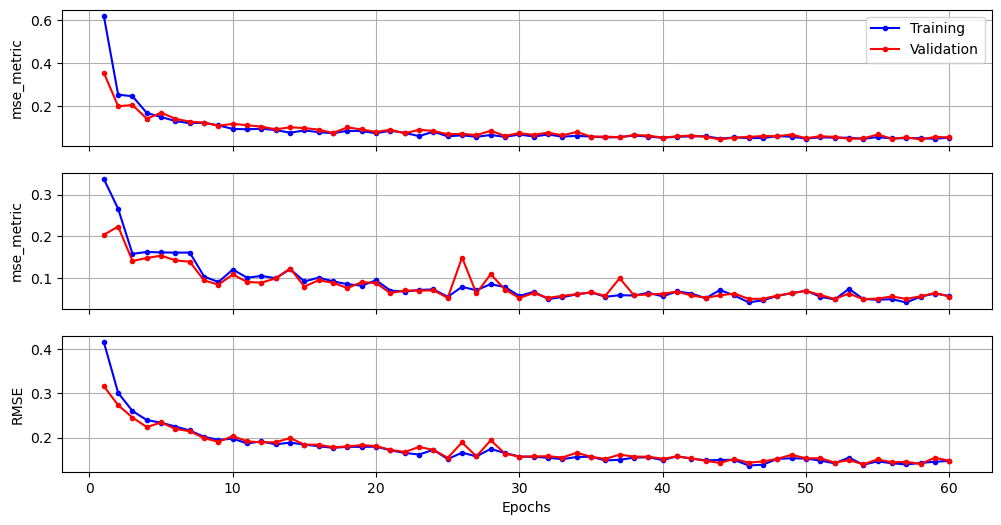

In [306]:
lepochs = list(range(1,params_train["num_epochs"] + 1))

fig, axs = plt.subplots(3, 1, figsize= (12,6), sharex=True)

axs[0].plot(lepochs, sm_metric_history['train_vwc'], marker='.', linestyle='-', color='b', label='Training')
axs[0].plot(lepochs, sm_metric_history['val_vwc'], marker='.', linestyle='-', color='r', label='Validation')
#axs[0].title('Validation Loss - SM')
axs[0].set_ylabel(metric_fn.__name__)
axs[0].grid(True)
axs[0].legend(bbox_to_anchor=(1,1))

axs[1].plot(lepochs, sm_metric_history['train_actevap'], marker='.', linestyle='-', color='b', label='Training')
axs[1].plot(lepochs, sm_metric_history['val_actevap'], marker='.', linestyle='-', color='r', label='Validation')
#axs[0].title('Validation Loss - SM')
axs[1].set_ylabel(metric_fn.__name__)
axs[1].grid(True)

axs[2].plot(lepochs, [i.detach().cpu().numpy() for i in sm_loss_history['train']], marker='.', linestyle='-', color='b', label='Training')
axs[2].plot(lepochs, [i.detach().cpu().numpy() for i in sm_loss_history['val']], marker='.', linestyle='-', color='r', label='Validation')
#axs[0].title('Validation Loss - SM')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel(loss_fn.__name__)
axs[2].grid(True)

In [307]:
model.load_state_dict(torch.load(f"{path2models}/weights.pt"))

<All keys matched successfully>

# Inference 

In [308]:
torch.cuda.empty_cache()

In [309]:
# predict over the whole spatial domain using the model trained over the subsample
yhat = predict(Xd_test, Xs, model, spatial_batch_size, device=device)
yhat.shape

(40140, 731, 2)

In [310]:
lat, lon, time = len(forcings.lat),len(forcings.lon), Xd_test.shape[1]
lat*lon ,time

(40140, 731)

In [311]:
# to original scale
yhat = (yhat*y_std) + y_m

## Volumetric Water Content (SM)

In [312]:
# reshape data for plotting
y_target, y_pred = prepare_for_plotting(y_target=Y_test[:,:,[0]], y_pred = yhat[:,:,[0]], shape = (lat, lon, time), coords = targets.sel(time=test_range).coords)
y_target.shape

(180, 223, 731)

In [313]:
# to original scale
y_target = (y_target*y_std[0]) + y_m[0]

In [314]:
y_target = y_target.chunk({"lat":20, "lon":20, "time":-1})

In [315]:
if remove_lakes:
    y_target = y_target.where(~mask_lakes[...,None])
    y_pred = y_pred.where(~mask_lakes[...,None])

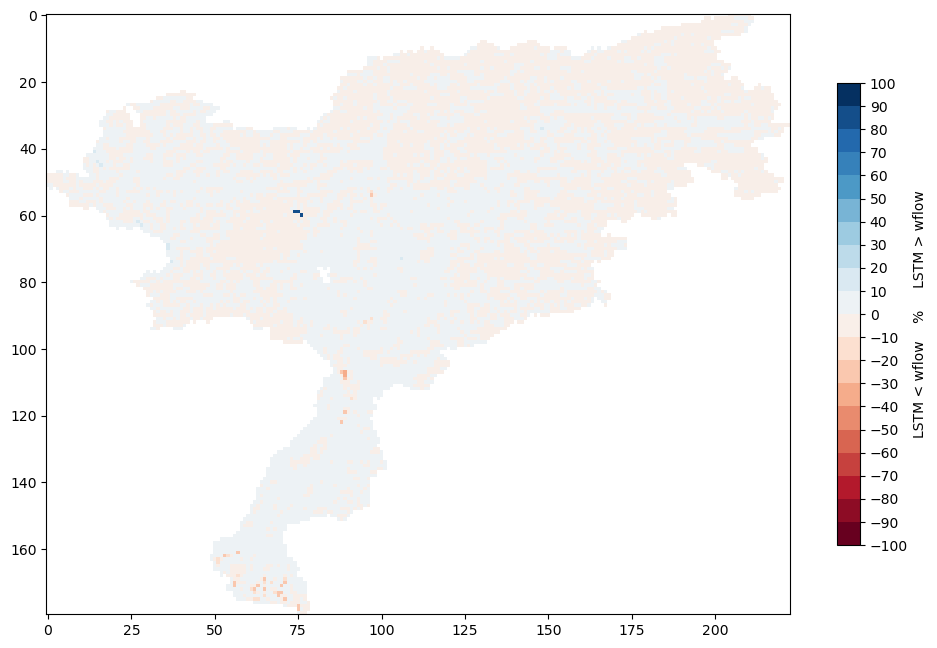

In [316]:
# map percent bias
map_pbias(y_target, y_pred, figsize = (12, 12), kwargs_imshow = {"vmin":-100, "vmax":100 })

In [266]:
# map bias
#map_bias(y_target, y_pred, figsize = (12, 12))

In [267]:
# correlation
# map_pearson(y_target, y_pred)

/home/iferrario/dev/hython/hython/viz.py:131: RuntimeWarning: All-NaN slice encountered
  xmin = np.nanmin( np.concatenate([iy, iyhat] )) - 0.05
/home/iferrario/dev/hython/hython/viz.py:132: RuntimeWarning: All-NaN slice encountered
  xmax = np.nanmax( np.concatenate([iy, iyhat] )) + 0.05


ValueError: Axis limits cannot be NaN or Inf

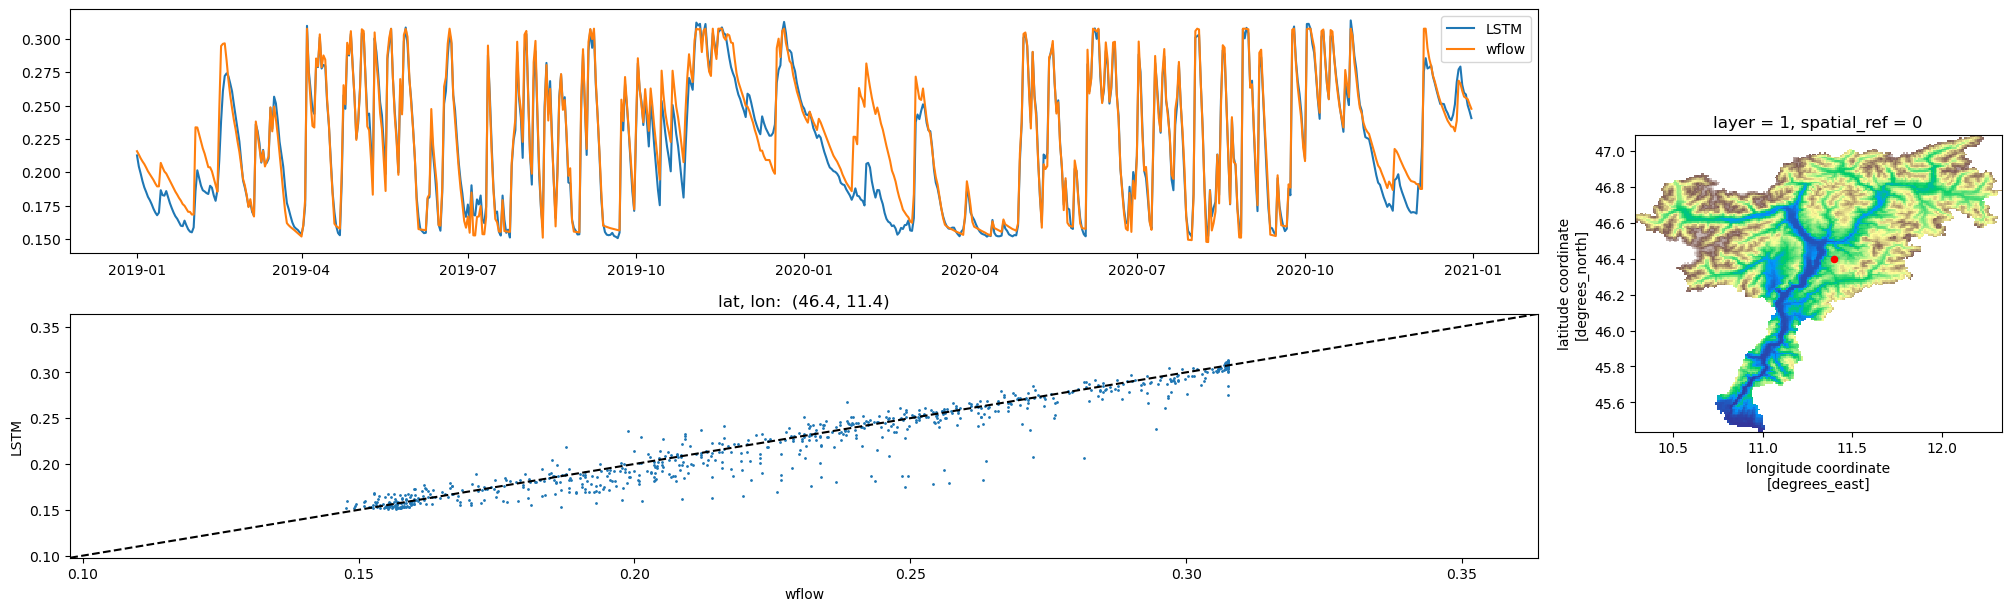

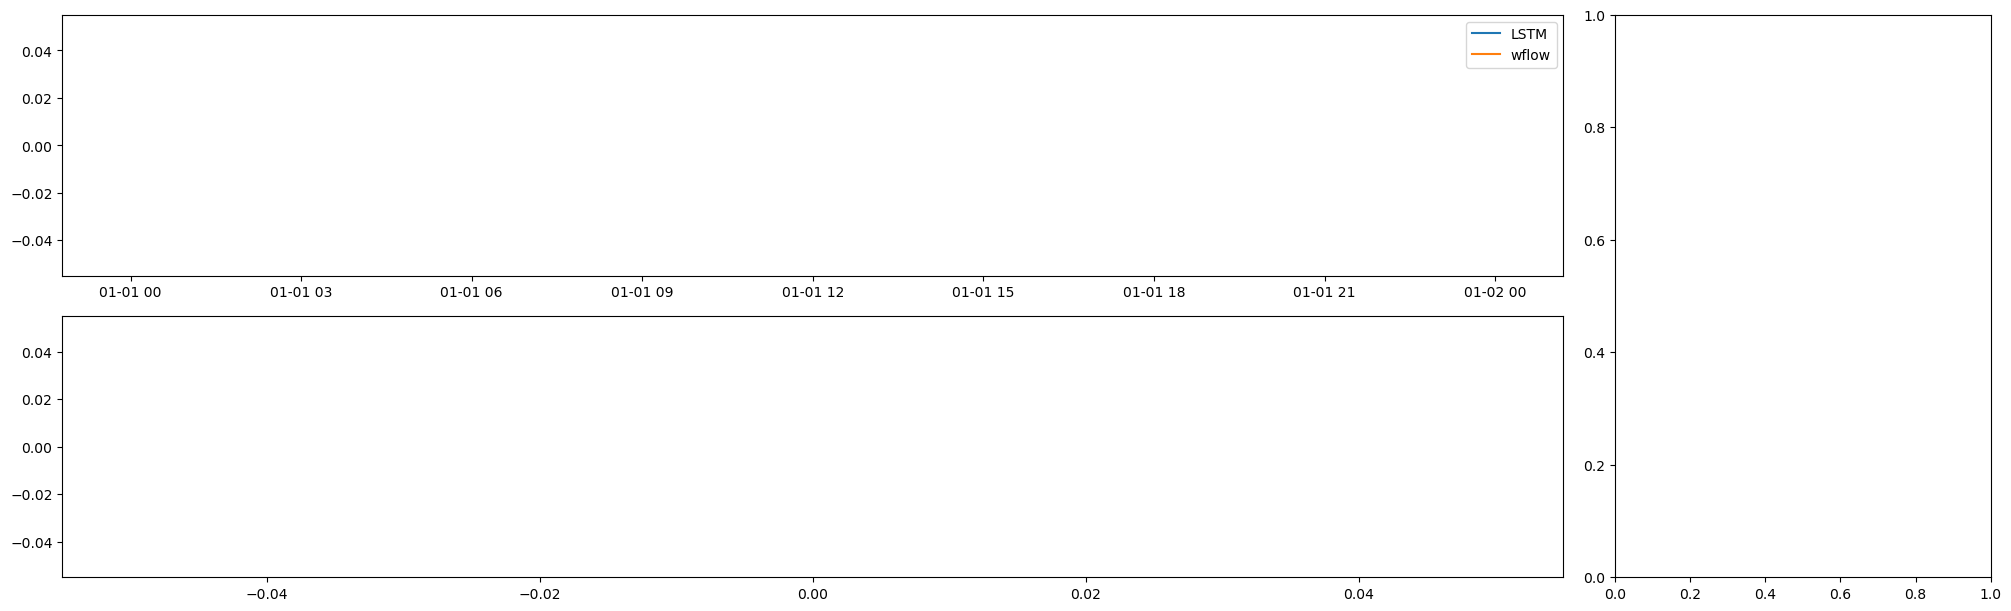

In [268]:
ts_compare(y_target, y_pred, lat = [46.4, 45, 46.5, 49, 46], lon = [11.4, 10, 10,12,8], bkg_map=wflow_dem)

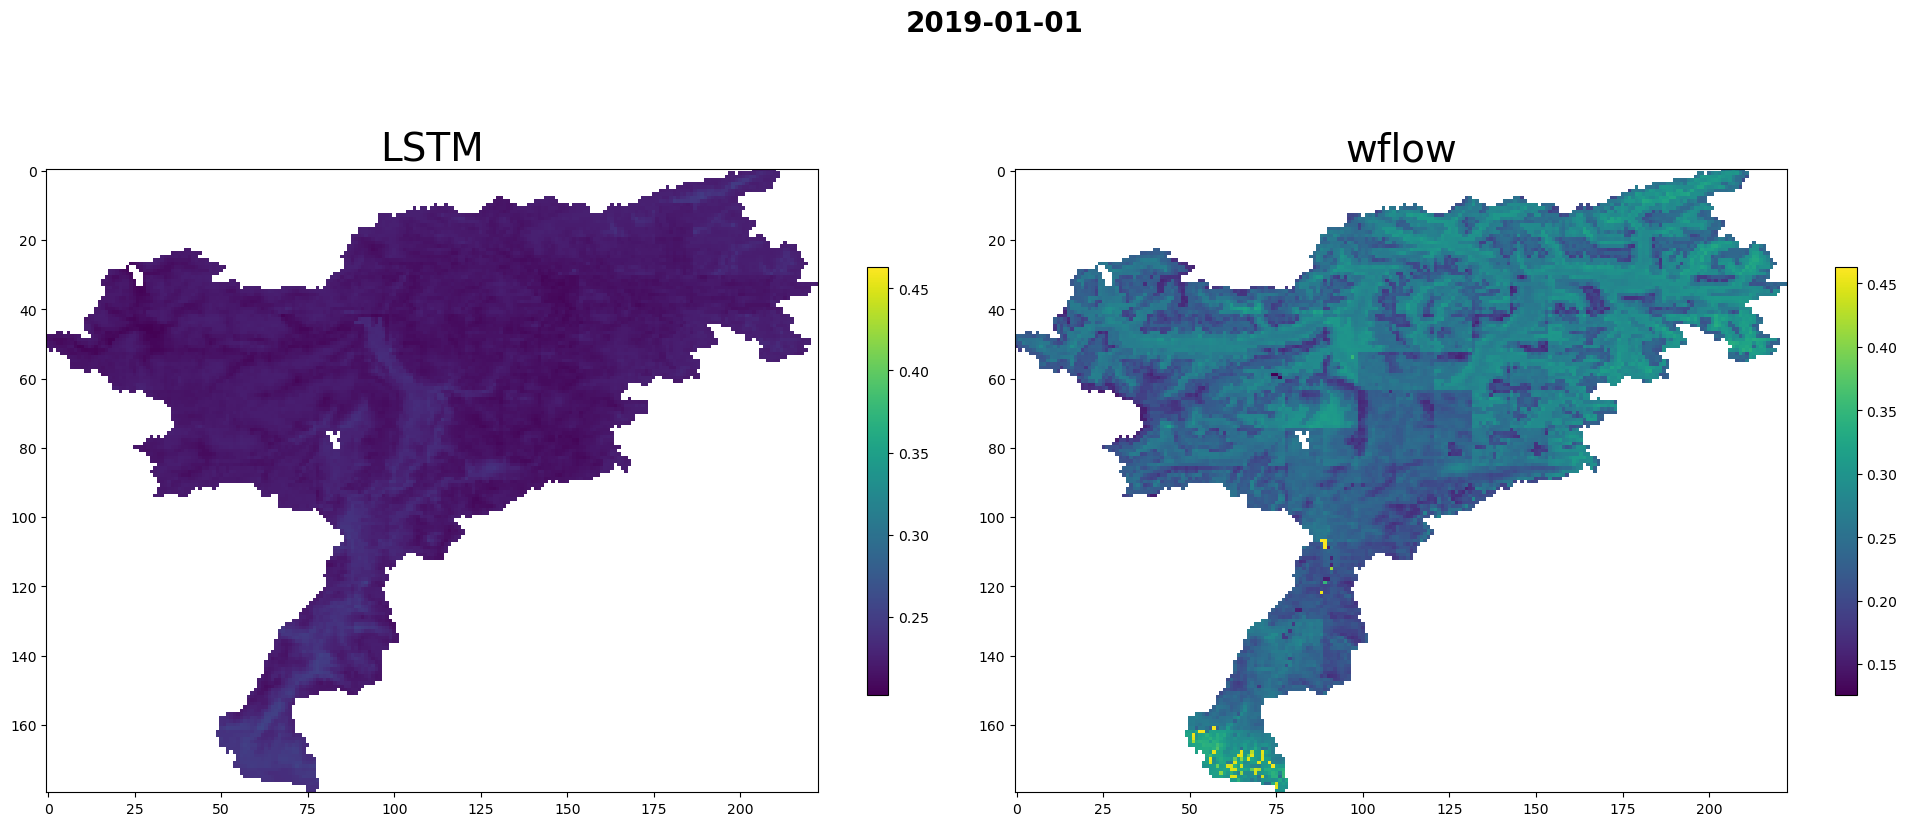

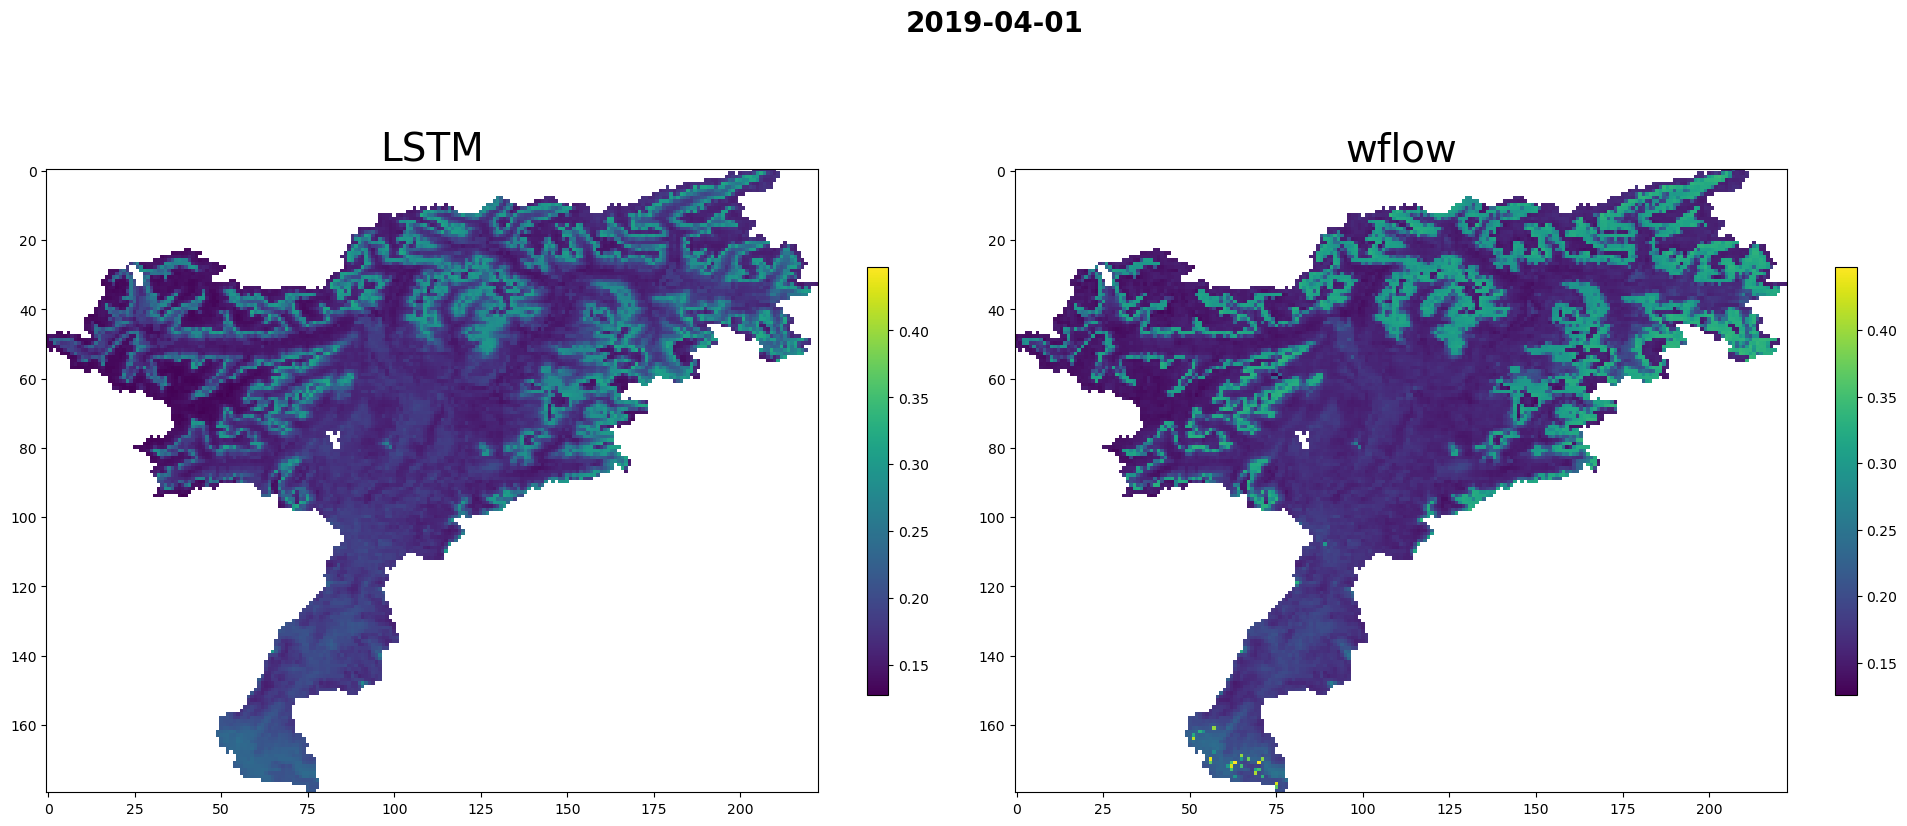

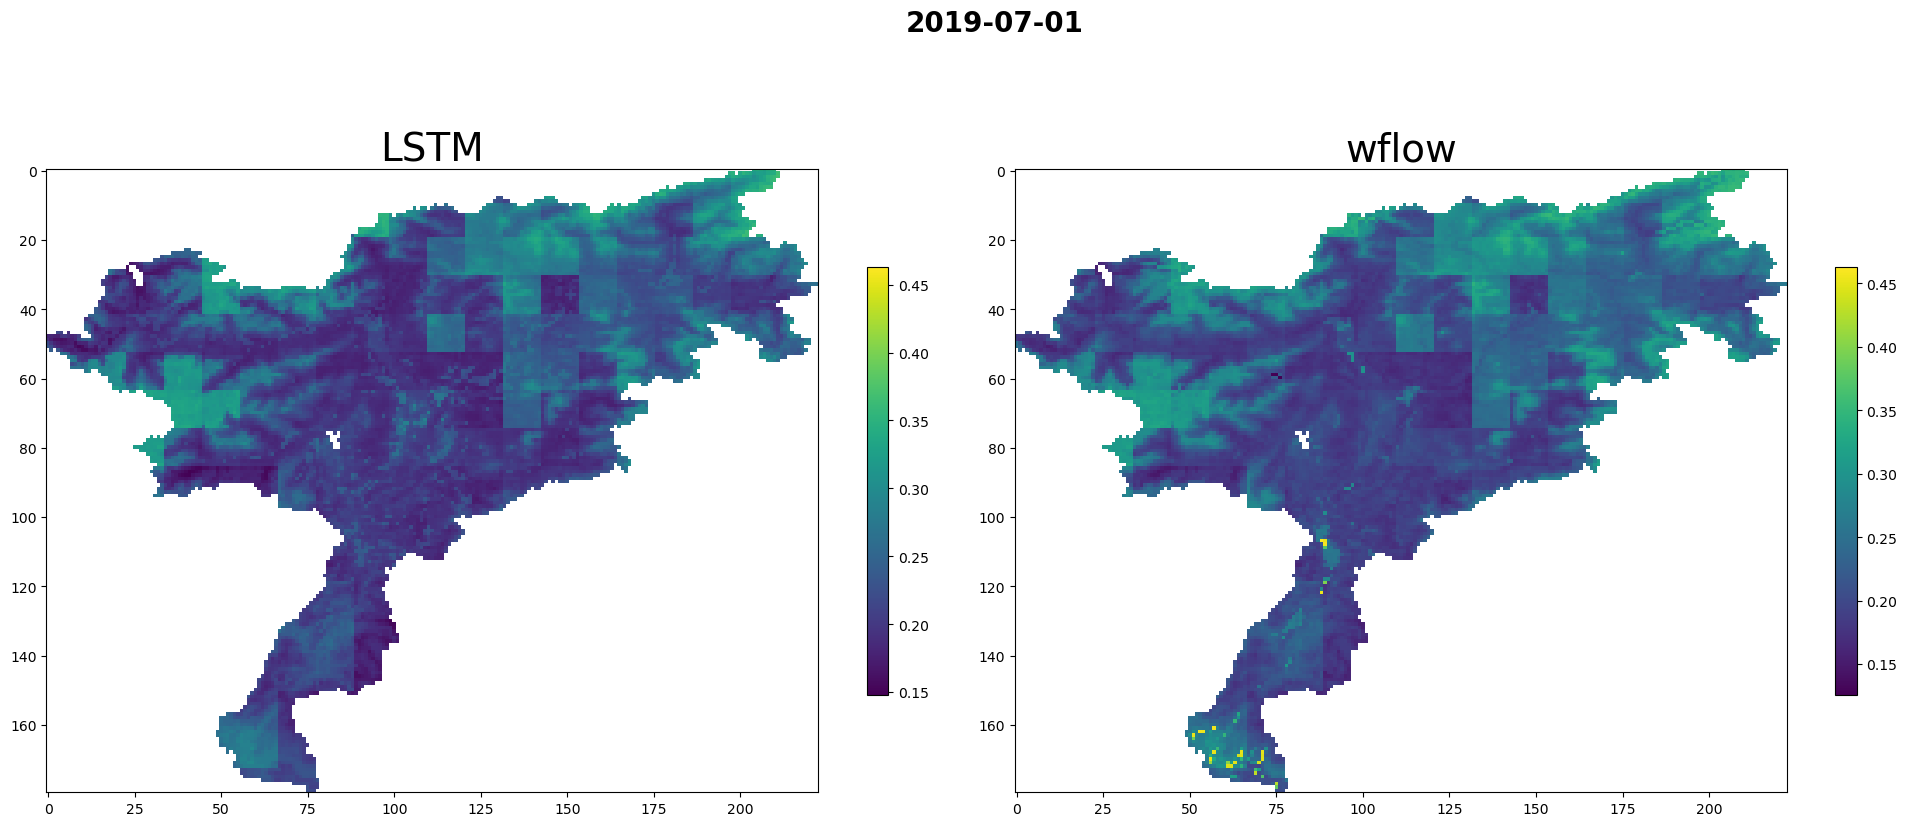

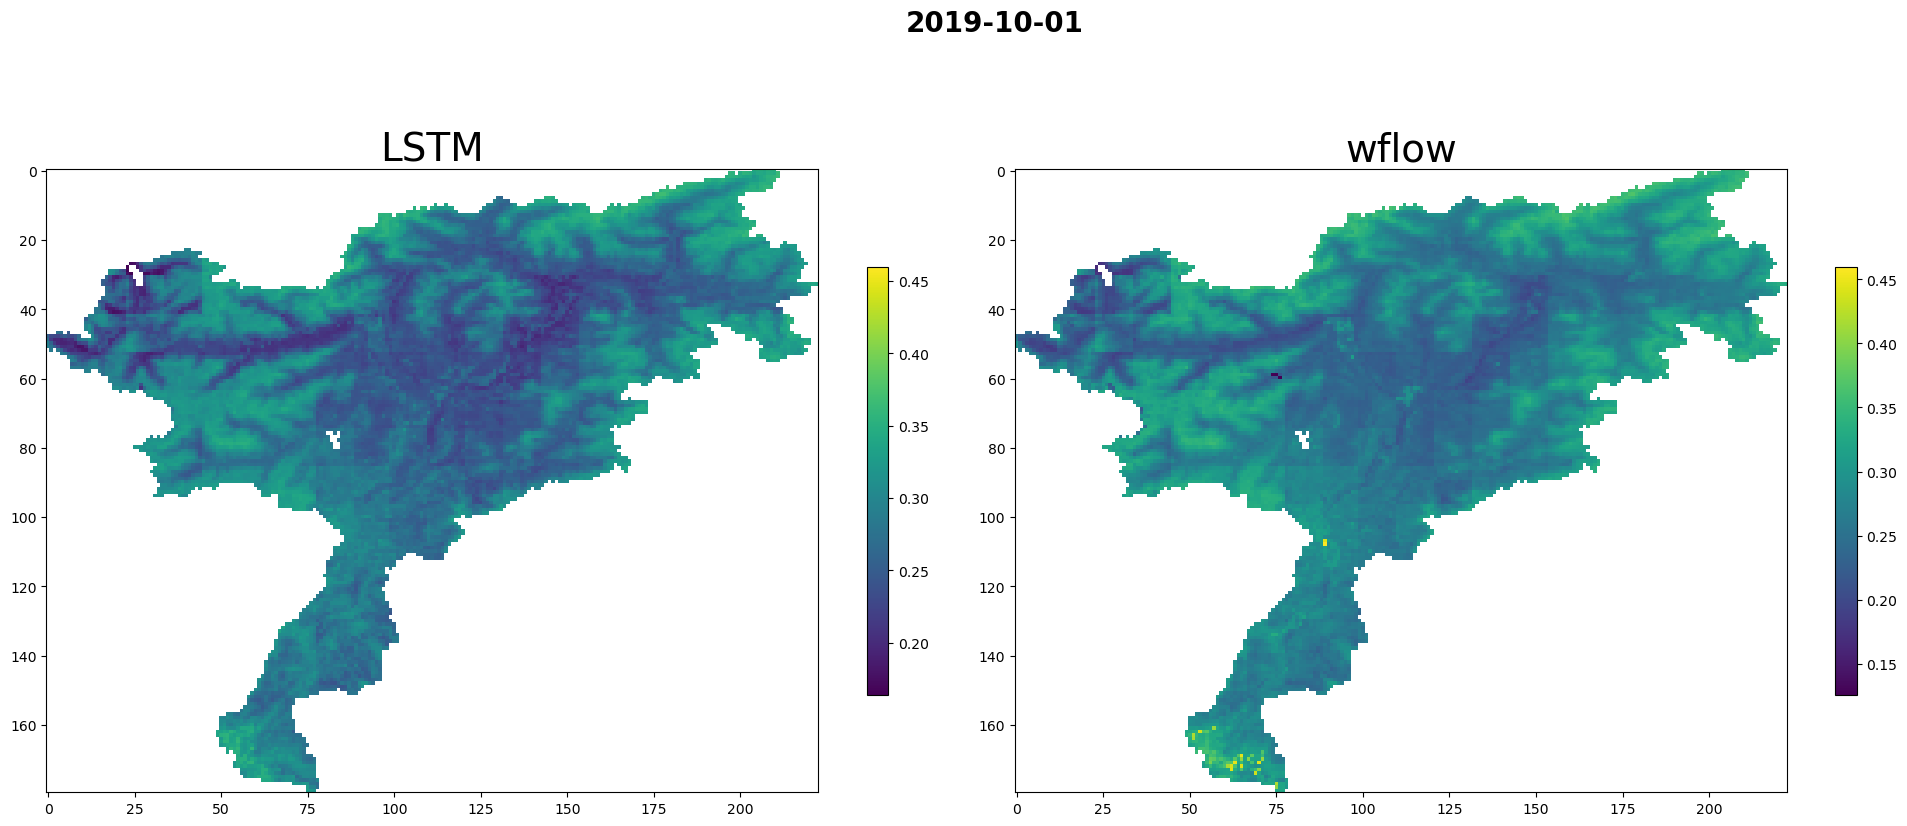

In [269]:
map_at_timesteps(y_target, y_pred,dates=["2019-01-01","2019-04-01", "2019-07-01", "2019-10-01"])

## ET

In [317]:
y_target_et, y_pred_et = prepare_for_plotting(y_target=Y_test[:,:,[1]], y_pred = yhat[:,:,[1]], shape = (lat, lon, time), coords  = targets.sel(time=test_range).coords)
y_target_et.shape

(180, 223, 731)

In [318]:
y_target_et = (y_target_et*y_std[1]) + y_m[1]

In [319]:
y_target_et = y_target_et.where(~mask_lakes[...,None])

y_pred_et = y_pred_et.where(~mask_lakes[...,None])

/home/iferrario/.local/miniforge/envs/emulator/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


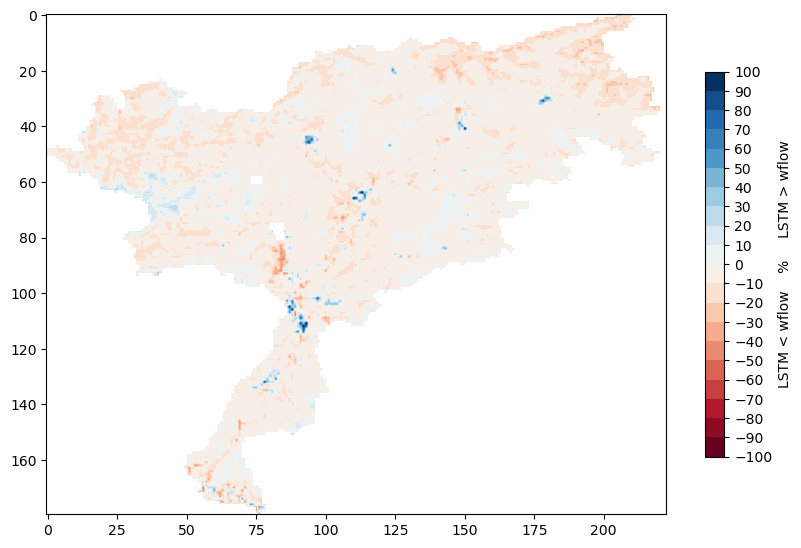

In [320]:
map_pbias(y_target_et, y_pred_et, figsize = (10, 10), kwargs_imshow = {"vmin":-100, "vmax":100 })

In [275]:
# correlation
# map_pearson(y_target_et, y_pred_et)

/home/iferrario/dev/hython/hython/viz.py:131: RuntimeWarning: All-NaN slice encountered
  xmin = np.nanmin( np.concatenate([iy, iyhat] )) - 0.05
/home/iferrario/dev/hython/hython/viz.py:132: RuntimeWarning: All-NaN slice encountered
  xmax = np.nanmax( np.concatenate([iy, iyhat] )) + 0.05


ValueError: Axis limits cannot be NaN or Inf

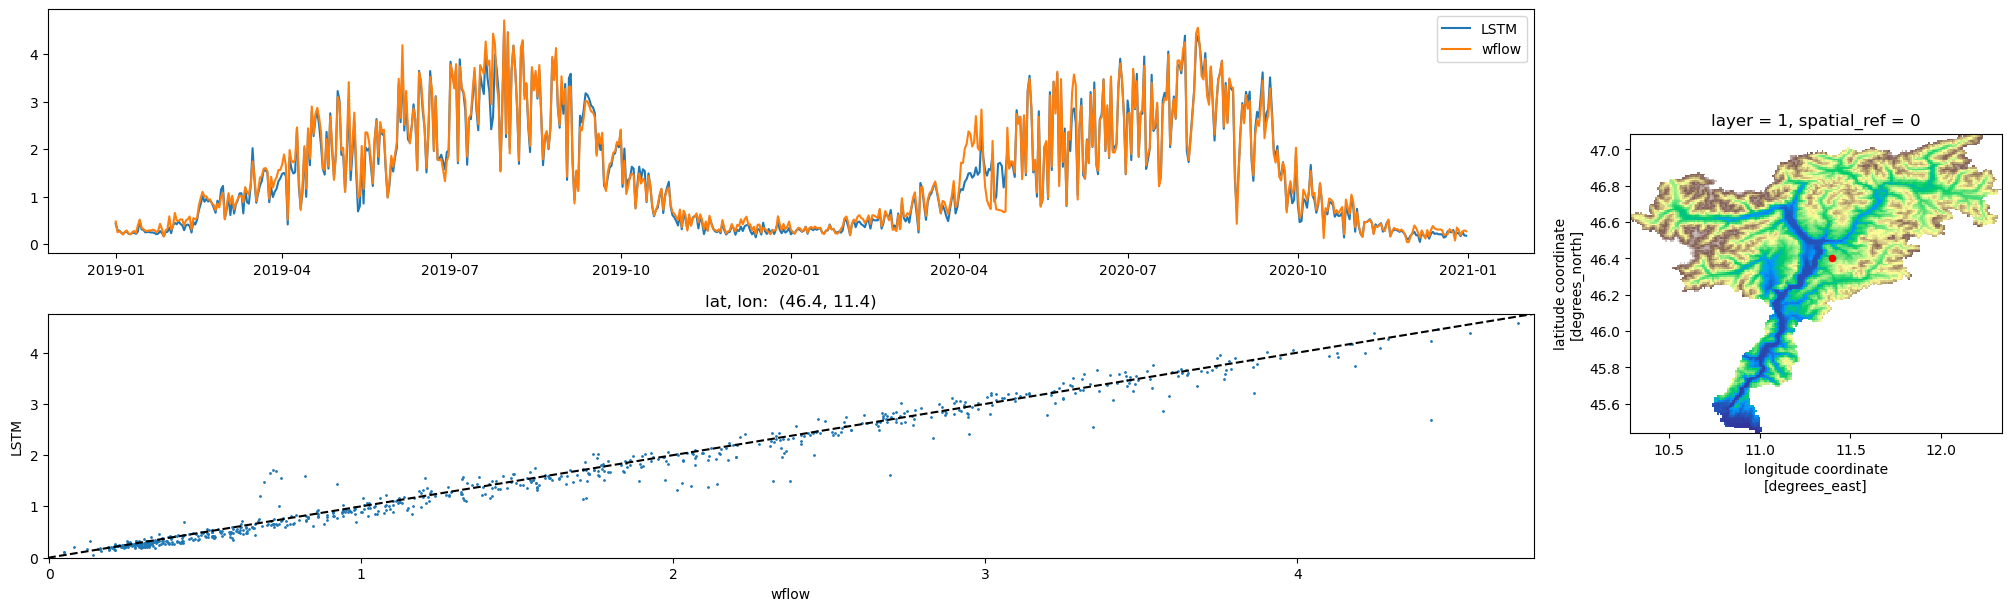

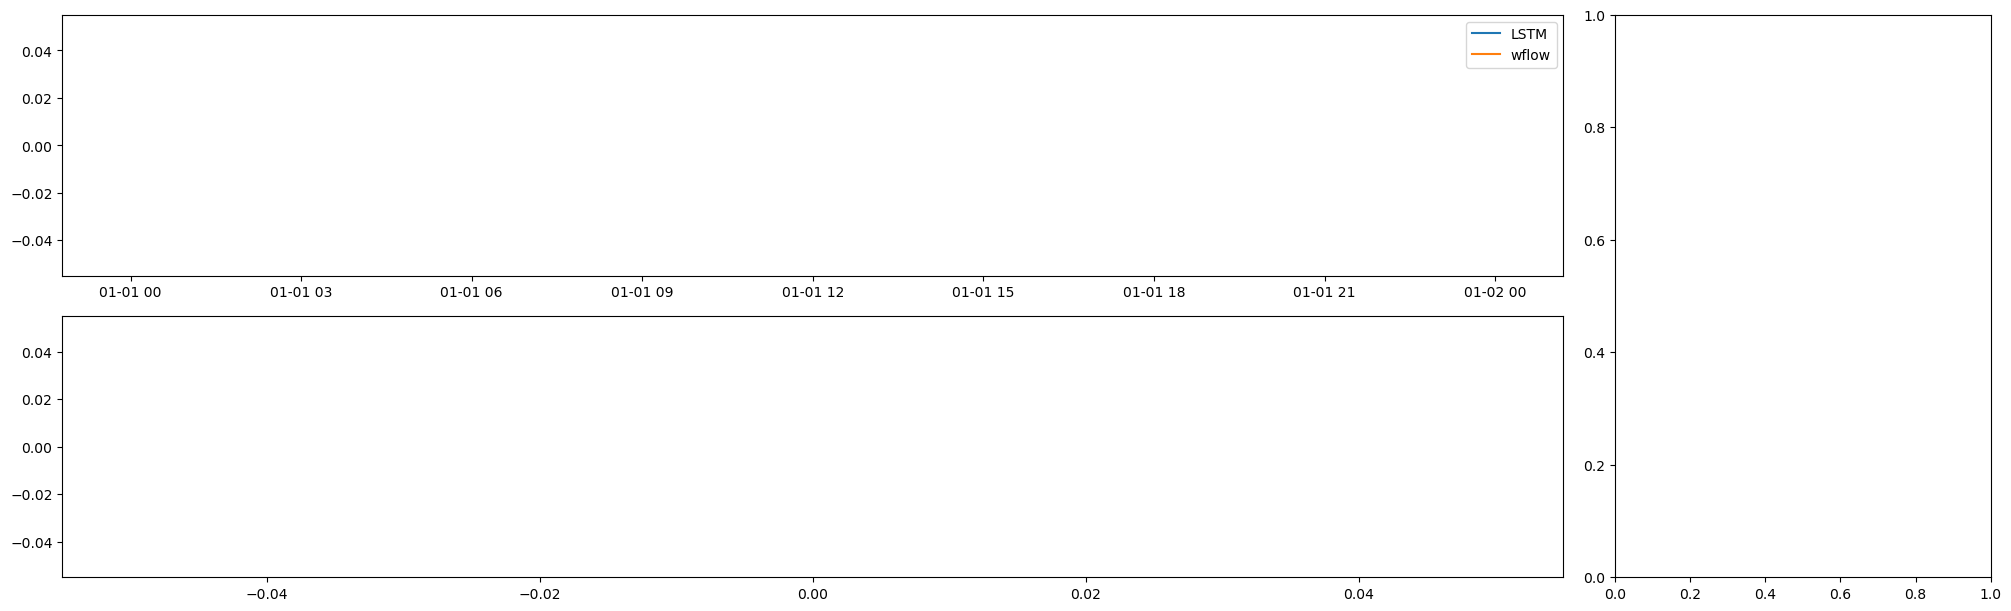

In [276]:
ts_compare(y_target_et, y_pred_et, lat = [46.4, 45, 46.5, 49, 46], lon = [11.4, 10, 10,12,8], bkg_map=wflow_dem)

In [ ]:
#plt.plot(np.unique(y_pred_et))

In [ ]:
map_at_timesteps(y_target_et, y_pred_et,dates=["2019-01-01","2019-04-01", "2019-07-01", "2019-10-01"])